# Classificação e BB para o MultMNIST


## 1 - Dowloands e configurações

### 1.1 - Dowloands

In [1]:
# Baixando lib pytorch_trainer_v2 do professor Lotufo
!wget -nc -q https://raw.githubusercontent.com/robertoalotufo/files/master/lib/pytorch_trainer_v2.py -Plib/
# !pip install opencv-python

### 1.2 - Importando os módulos

In [2]:
GOOGLE_COLAB = False

if GOOGLE_COLAB:
    from os import path
    from wheel.pep425tags import get_abbr_impl, get_impl_ver, get_abi_tag

    platform = '{}{}-{}'.format(get_abbr_impl(), get_impl_ver(), get_abi_tag())
    accelerator = 'cu80' if path.exists('/opt/bin/nvidia-smi') else 'cpu'

    !pip3 install http://download.pytorch.org/whl/{accelerator}/torch-0.4.1-{platform}-linux_x86_64.whl torchvision

    # PIL workaround 
    from PIL import Image
    def register_extension(id, extension): Image.EXTENSION[extension.lower()] = id.upper()
    Image.register_extension = register_extension
    def register_extensions(id, extensions): 
        for extension in extensions: register_extension(id, extension)
    Image.register_extensions = register_extensions
    
import time
import os
import copy
import pickle
from math import sqrt, pow
import traceback
from random import random
from collections import OrderedDict
import multiprocessing as mp
from PIL import Image
import glob
import matplotlib.pyplot as plt
from matplotlib import patches, patheffects
import numpy as np
from numpy import array as a
import cv2
import torch
from torch import cuda
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim import lr_scheduler
import torchvision
from torchvision import datasets, models, transforms
from torchvision.datasets import MNIST
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from torchvision.utils import make_grid
from torchvision import transforms

from lib import pytorch_trainer_v2 as ptt
        
if torch.cuda.is_available():
    device = torch.device("cuda:0")
    torch.set_default_tensor_type('torch.cuda.FloatTensor')
else:
    device = torch.device("cpu")
    torch.set_default_tensor_type('torch.FloatTensor')
   
  
from sklearn.model_selection import train_test_split

print("Tudo pronto!")

Tudo pronto!


### 1.3 - Checando memoria e Gpu

In [3]:
!free -m    
!nvidia-smi

              total        used        free      shared  buff/cache   available
Mem:         245854        1084      241729           8        3040      243330
Swap:             0           0           0
Tue Dec 11 07:06:34 2018       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 396.44                 Driver Version: 396.44                    |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  On   | 00000000:00:1B.0 Off |                    0 |
| N/A   50C    P0    46W / 300W |     11MiB / 16160MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   1  Tesla V100-SXM2...  On   | 00000000:0

### 1.4 - Configurações de execuçao

In [4]:
global_retrain = True                      # Recria o dataset e treina do zero
global_recreate_dataset = True             # Força a recriação de todo o dataset
global_image_size=(160, 160)               # Tamanho da imagem que será gerada 
global_grid_sizes = [5, 10]                # Tamanho dos grids no target
global_num_scales = len(global_grid_sizes) # Quatidade de esclass
global_num_numbers = 4                     # Qtde de numeros por imagem
global_max_num_len = 6                     # Qtde maxima de digitos por numero
global_mult_gpu = cuda.device_count() > 1  # Executar em multi GPUs
global_bb_size = (14, 28)                  # Tamanho do BB (min size, max size) 
global_number_samples = 25000              # Numero de amostras que serão geradas
global_number_epochs = 100                  # Numero de epochs no treinamento
global_root_path = "./CustomizedMNIST/"    # Raiz onde os dados serão salvos

### 1.5 - Funções uteis

In [5]:
class ImageUtil():
    """ Classe com diversos métodos uteis para manipulação de imagens """

    @staticmethod
    def open_image(fn, gray=True):
        """ Opens an image using OpenCV given the file path.

        Arguments:
            fn: the file path of the image

        Returns:
            The image in RGB format as numpy array of floats normalized to range between 0.0 - 1.0
        """
        
        flags = 0
        if not gray:
            flags = cv2.IMREAD_UNCHANGED + cv2.IMREAD_ANYDEPTH + cv2.IMREAD_ANYCOLOR
        
        if not os.path.exists(fn) and not str(fn).startswith("http"):
            raise OSError('No such file or directory: {}'.format(fn))
        elif os.path.isdir(fn) and not str(fn).startswith("http"):
            raise OSError('Is a directory: {}'.format(fn))
        else:
            try:
                if str(fn).startswith("http"):
                    req = urllib.urlopen(str(fn))
                    image = np.asarray(bytearray(req.read()), dtype="uint8")
                    im = cv2.imdecode(image, flags).astype(np.float32) #/ 255
                else:
                    im = cv2.imread(str(fn), flags).astype(np.float32) #/ 255
                if im is None: raise OSError(f'File not recognized by opencv: {fn}')
                if not gray:
                    return cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
                return im
            except Exception as e:
                raise OSError('Error handling image at: {}'.format(fn)) from e

                
    @staticmethod
    def show_img(im, figsize=None, ax=None):
        """ Mostra uma imagem e retorna o ax """
        if not ax: fig, ax = plt.subplots(figsize=figsize)
        ax.imshow(im, cmap='gray')
        plt.grid(False)
        return ax

      
    @staticmethod
    def _draw_outline(o, lw, foreground='black'):
        """ Desenha outline """
        o.set_path_effects([patheffects.Stroke(
            linewidth=lw, foreground=foreground), patheffects.Normal()])

        
    @staticmethod
    def draw_rect(ax, b, edgecolor='white', foreground='black', lw=3):
        """ Desenha o retangulo com coord em b """
        patch = ax.add_patch(patches.Rectangle((b[0], b[1]), b[2], b[3], fill=False, edgecolor=edgecolor, lw=lw))
        return ax

    
    @staticmethod        
    def draw_text(ax, xy, txt, sz=16, color='green', d=0):
        """ Desenha um texto """
        text = ax.text(*(np.array(xy) - d), txt, verticalalignment='top', color=color, fontsize=sz, weight='bold')
        
    
    @staticmethod
    def plot_image(img, title="Imagem"):
        """Plota uma image sem retornar o ax"""
        if len(img.shape) > 3: img = img.squeeze(0)
        plt.imshow(img, cmap='gray')
        plt.title(title)
        plt.grid(False)
        plt.show()

    
    @staticmethod
    def show_grid(array, title="Target", reshape_to=(5, 1, 12, 12)):
        """ Plot um grid com varias images: util para plotagem de targets"""
        array = torch.tensor(array).reshape(reshape_to) #.unsqueeze(1)
        grid = make_grid(array, nrow=5, normalize=True, padding=1, pad_value = 0.5).numpy().transpose(1, 2, 0)

        plt.imshow(grid)
        plt.title(title)
        plt.grid(False)
        plt.show()

## 2 - Criação do dataset e dataloader


### 2.1 - Gerador do Cusomized MINIST

In [6]:
class CreatorCustomizedMNIST:
    """ 
    Manipulador de amostras custumizada do MNIST 
    """
    
    def __init__(self, root=global_root_path, image_size=global_image_size, 
                 min_max_bb_size=global_bb_size, num_numbers=global_num_numbers, 
                 max_num_len=global_max_num_len):
        
        # Parametros
        self.image_size = image_size  
        self.min_max_bb_size = min_max_bb_size
        self.anchor_space = np.array(image_size) - np.array([min_max_bb_size[1], 0])
        self.num_numbers = num_numbers
        self.max_num_len = max_num_len
        
        # Dataset e dataloader para o MNIST original
        mnist = datasets.MNIST(root=root, train=True, transform=transforms.ToTensor(), download=True)
        self.mnist_loader = DataLoader(mnist, batch_size=1, shuffle=True, num_workers=0)
        self.iter = iter(self.mnist_loader)
        
        # Path onde será criadas as imagens e os targets
        self.x_path = os.path.join(root, "x")
        self.y_path = os.path.join(root, "y")
        
    
    def _bb_intersection(bb1, bb2):
        """
        Verifica se os dois retangulos tem interceção
        """
        maxX = max(bb1[0][0], bb2[0][0])
        minX = min(bb1[1][0], bb2[1][0])
        maxY = max(bb1[0][1], bb2[0][1])
        minY = min(bb1[1][1], bb2[1][1])

        if maxX >= minX or minY <= maxY:
            return False

        return True

    
    def _get_random_points(self):
        """ 
        Gera um conjunto de pontos que naõ se cruzam dentro de um espaco 
        (respeitando min_dist na diagonal) 
        """ 
        npoints = self.num_numbers
        anchor_points, i = [], 0
        num_len = np.random.randint(1, self.max_num_len + 1)
        
        while i < npoints:
            
            # Sorteia um ponto aleatoriamente
            p = (np.random.rand(2) * self.anchor_space).astype(np.int)
            size = np.random.randint(self.min_max_bb_size[0], self.min_max_bb_size[1] + 1)
            
            
            #---------Verifica se teve conflito------------#
            conflict = p[1] + size * num_len >= self.anchor_space[1]
            
            if not conflict:
                for p_i, size_i, num_len_i in anchor_points:
                    
                    if CreatorCustomizedMNIST._bb_intersection([a(p)-2, a([p[0] + size, p[1] + num_len * size])+2], 
                                    [a(p_i)-2, a([p_i[0] + size_i, p_i[1] + num_len_i * size_i])+2]):
                        
                        conflict = True
                        break;
                        
                if not conflict:
                    anchor_points.append((p, size, num_len)) 
                    i += 1
                    num_len = np.random.randint(1, self.max_num_len + 1)
            #----------------------------------------------#
        
        # Retorna o conjunto de pontos
        return anchor_points
            
    
    
    def _get_MNIST_sample(self):
        # Pega uma imagem do MNIST
        try:
            sample = next(self.iter)
        except StopIteration:
            self.iter = iter(self.mnist_loader)
            sample = next(self.iter)
            
        return sample
     
        
    def make_sample(self):
        """ 
        Gera uma amostra custumizada do MNIST - Conforme configurações de inicialização 
        """
        
        # Pontos sorteados, reduação (da imagem para o target) e size do target
        anchor_points = self._get_random_points()
        
        # Inicializa a nova imagem e target
        sample = np.zeros(self.image_size)
        target_list = [np.zeros((5, item, item)) for item in global_grid_sizes]
        
        # Inserindo os digitos na imagem de saida 
        for point, size, num_len in anchor_points:
            
            # Calcular o BB medio para definir qual escala pertence
            index = int(size > ((self.min_max_bb_size[0] + self.min_max_bb_size[1]) / 2))
            reduce_y_by = self.image_size[0] // global_grid_sizes[index]
            
            # Calcula tx e ty
            c_point = point + (size // 2, (size * num_len) // 2)
            tx = (c_point[1] % reduce_y_by) / (1.0 * reduce_y_by)
            ty = (c_point[0] % reduce_y_by) / (1.0 * reduce_y_by) 
            
            # Preenche o sample e o target
            for i in range(num_len):
                img, _ = self._get_MNIST_sample()
                img = cv2.resize(img.squeeze().numpy(), (size, size))
                pos_x, pos_y = point[0], point[1] + (i * size)
                sample[pos_x:pos_x + size, pos_y:pos_y + size] = img
            
            pos_x, pos_y = c_point[0] // reduce_y_by, c_point[1] // reduce_y_by
            size_norm = (size * 1.0) / self.min_max_bb_size[1] # Divide pelo maior BB possivel
            num_len_norm = (num_len * 1.0) / self.max_num_len # Divide pela quatidade max de digitos 
            
            target_list[index][:, pos_x, pos_y] = (1, tx, ty, size_norm, num_len_norm) 
            
        return sample, target_list
    

### 2.2 - Utilitarios para o novo dataset

In [7]:
class CustmizedMNISTUtil:
    
    @staticmethod
    def predict_to_target_shape(predicts):
        """ 
        Pega os indexs maximos nas valores que são classificação. 
        """

        # Tensor de retorno
        target_list = []
        
        # Percorre todas as escalas
        for i in range(len(predicts)):
            target = np.zeros((6, global_grid_sizes[i], global_grid_sizes[i]))
            
            # Presença
            max_values, idx_max_presence = torch.max(predicts[i][0:2, :, :].cpu().detach(), 0)
            
            # Preenche o tensor de retorno
            target[0, :, :] = idx_max_presence
            target[1:5, :, :] = predicts[i][2:, :, :].cpu().detach().numpy()
            target[5, :, :] = max_values
            
            target_list.append(target)

        return target_list

    
    @staticmethod
    def non_max_suppression(bbs):
        """
        Realiza o Non Max Suppression
        """
        
        bbox_final, new_bb, iou, amin = [], True, 0, 0.1
        for i in range(len(bbs)):
            new_bb, iou = True, 0
            for j in range(len(bbox_final)):
                iou = 0.
                x1 = max(bbs[i][0][0], bbox_final[j][0][0])
                y1 = max(bbs[i][0][1], bbox_final[j][0][1])
                x2 = min(bbs[i][0][0] + bbs[i][0][2], bbox_final[j][0][0] + bbox_final[j][0][2])
                y2 = min(bbs[i][0][1] + bbs[i][0][3], bbox_final[j][0][1] + bbox_final[j][0][3])
    
                if x1>x2 or y1>y2:
                    iou = 0
                else:
                    iou = (x2-x1) * (y2-y1)
                    iou = iou/(bbs[i][0][2] * bbs[i][0][2] + bbox_final[j][0][2] * bbox_final[j][0][2] - iou)
                if iou >= amin:
                    new_bb = False
                    if bbs[i][1] > bbox_final[j][1]: #seleciona bbox com maior probabilidade de classe
                        bbox_final[j] = bbs[i]
            if new_bb == True:
                bbox_final.append(bbs[i])

        return bbox_final
    
    
    @staticmethod
    def construct_bb(target_all, predict=False, image_size=global_image_size, 
                     max_num_len=global_max_num_len, min_max_bb_size=global_bb_size):
        """ 
        Controi os BB a parti dos dados do target 
        """
        
        bbs, count, probability = [],  0, 1
       
        for target in target_all: #Escalas
            for i in range(target.shape[1]):  # Grid
                for j in range(target.shape[2]): # Grid
                    if target[0][i][j] == 1: # Presença
                        reduced_y_by = image_size[0] // global_grid_sizes[count]
                        height = target[3][i][j] * min_max_bb_size[1] # Largua do BB
                        width = target[4][i][j] * max_num_len * height # Altura do BB
                        tx, ty = target[1][i][j] * reduced_y_by, target[2][i][j] * reduced_y_by # Deslocamento
                        point = (i * reduced_y_by - height // 2 + ty, j * reduced_y_by - width // 2 + tx) # Posição
                        if predict: probability = target[5][i][j]
                        bbs.append(([point[1], point[0], width, height], probability)) # BB
            count += 1

        return bbs

    
    @staticmethod
    def show_sample(img, target, predict=None, image_size=global_image_size):
        """ 
        Mostrar uma imagem com seus bb targets e predicts e suas classes
        """
        
        # Plota a imagem e retorna o ax
        ax = ImageUtil.show_img(img.reshape(image_size))

        # Controi todos os BB do target
        bbs_target = CustmizedMNISTUtil.construct_bb(target)        
        # Plot os BB e suas respectivas classes se ainda não estiver sido plotada
        for bb_target in bbs_target:
            ImageUtil.draw_rect(ax, bb_target[0], 'green', lw=3)
                
                
        # Verifica se a predição foi passada
        if predict is not None:
            # Aplica o softmax na parte que é classificação
            predict = CustmizedMNISTUtil.predict_to_target_shape(predict)
            
            # Controi todos os BB do predict
            bbs_predict = CustmizedMNISTUtil.construct_bb(predict)
            
            # Aplica o Non Max Supression
            bbs_predict = CustmizedMNISTUtil.non_max_suppression(bbs_predict)
            
            # Plot os BB e suas respectivas classes
            for bb_predict in bbs_predict:
                ImageUtil.draw_rect(ax, bb_predict[0], 'red', lw=2)

### 2.3 - Visualizados alguns exemplos

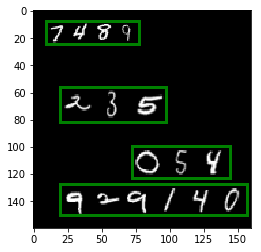

In [8]:
creatorMNIST = CreatorCustomizedMNIST()
x, y = creatorMNIST.make_sample()
CustmizedMNISTUtil.show_sample(x, y)

### 2.5 - Classe dataset 

Transformações

In [9]:
class ToTensor(object):
    """ Converte sampels para tensor do Torch """
    
    def __call__(self, npimage):
        # Normaliza entre [0-1] e converte oara torch.Tensor 
        return torch.unsqueeze(torch.from_numpy(npimage), 0).float()


Classe do novo dataset

In [10]:
class CustomizedMNISTDataset(Dataset):
    """ Classe dataset com os samples custumizados """
    
    def __init__(self, number_samples, transform=None):
        self.number_samples = int(number_samples)
        self.transform = transform
        
        # Transformações
        if self.transform is None:
            self.transform = ToTensor()
        
        creatorMNIST = CreatorCustomizedMNIST()
        self.list_samples = []
        for i in range(self.number_samples):
            x, y = creatorMNIST.make_sample()
            self.list_samples.append((x, y))
    
    def __len__(self):
        return self.number_samples
    
    def __getitem__(self, i):
        return self.transform(self.list_samples[i][0]), self.list_samples[i][1]
        

### 2.6 - DataLoaders

In [11]:
# Tamanho do batch
batch_size = 32

# Carrega os dados e cria os datasets
dataset_train = CustomizedMNISTDataset(number_samples=0.8*global_number_samples)
dataset_val = CustomizedMNISTDataset(number_samples=0.2*global_number_samples)

print("Len(Train): {}\nLen(Val): {}".format(len(dataset_train), len(dataset_val)))

# Cria os dataloaders
dataloader_train = DataLoader(dataset_train, batch_size=batch_size)
dataloader_val = DataLoader(dataset_val, batch_size=batch_size)

Len(Train): 20000
Len(Val): 5000


### 2.7 - Verificando o resultado pelo dataloader

Shapes batch:  (160, 160) [torch.Size([32, 5, 5, 5]), torch.Size([32, 5, 10, 10])]
X - shape:  torch.Size([160, 160]) min:  tensor(0., device='cpu') max:  tensor(1., device='cpu')


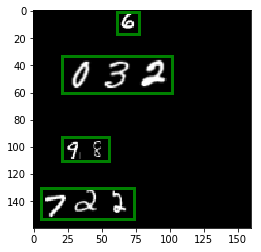

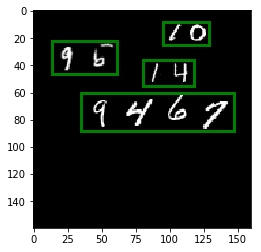

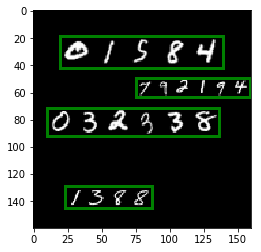

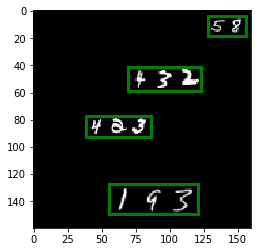

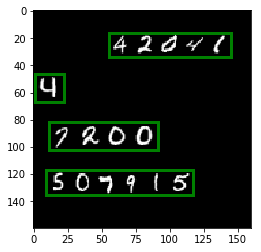

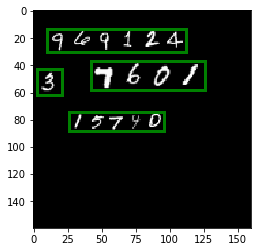

In [12]:
# 1 batch de treinamento
xs, ys = next(iter(dataloader_train))
print("Shapes batch: ", x.shape, [ys[i].shape for i in range(len(ys))])

count = 0

# Plota um exemplo
for x, y1, y2 in zip(xs, ys[0], ys[1]):
    CustmizedMNISTUtil.show_sample(x, [y1, y2])
    if count >= 5: break
    count += 1
    
print("X - shape: ", x[0].shape, "min: ", x[0].min(), "max: ", x[0].max())

## 3 - Modelo Totalmente Convolucional

In [13]:
class MyModelFullyConv(nn.Module):
    """ Modelo TC utilizado """
    
    def __init__(self):
        super(MyModelFullyConv, self).__init__()
        
        # Camadas convolucionais
        self.conv_layer = nn.Sequential(OrderedDict([
            
            ('conv1', nn.Conv2d(in_channels=1, out_channels=8, kernel_size=3, padding=1)),
            ('relu1', nn.ReLU()),
            ('batch_norm11', nn.BatchNorm2d(8)),
            
            ('conv2', nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3, padding=1)),
            ('relu2', nn.ReLU()),
            ('batch_norm12', nn.BatchNorm2d(16)),
            
            ('max_pool1', nn.MaxPool2d(2)),
            ('batch_norm1', nn.BatchNorm2d(16)),

            ('conv3', nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1)),
            ('relu3', nn.ReLU()),
            ('batch_norm13', nn.BatchNorm2d(32)),
            
            ('conv4', nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)),
            ('relu4', nn.ReLU()),
            ('batch_norm14', nn.BatchNorm2d(64)),
            
            ('max_pool2', nn.MaxPool2d(2)),
            ('batch_norm2', nn.BatchNorm2d(64)),
            
            ('conv5', nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1)), 
            ('relu5', nn.ReLU()),
            ('batch_norm15', nn.BatchNorm2d(128)),
            
            ('conv6', nn.Conv2d(in_channels=128, out_channels=64, kernel_size=3, padding=1)),
            ('relu6', nn.ReLU()),
            ('batch_norm16', nn.BatchNorm2d(64))
        ]))
        
        # saida 20 x 20
        self.conv_layer_1 = nn.Sequential(OrderedDict([
            ('max_pool4', nn.MaxPool2d(2)),
            ('batch_norm4', nn.BatchNorm2d(64)),
            
            ('conv8', nn.Conv2d(in_channels=64, out_channels=32, kernel_size=3, padding=1)), 
            ('relu8', nn.ReLU()),
            ('batch_norm16', nn.BatchNorm2d(32)),
            
            ('max_pool5', nn.MaxPool2d(2)),
            ('batch_norm5', nn.BatchNorm2d(32)),
            
            ('conv9', nn.Conv2d(in_channels=32, out_channels=16, kernel_size=3, padding=1)), 
            ('relu9', nn.ReLU()),
            ('batch_norm17', nn.BatchNorm2d(16)),
            
            ('conv10', nn.Conv2d(in_channels=16, out_channels=6, kernel_size=3, padding=1)), 
            ('relu10', nn.ReLU()),
            ('batch_norm18', nn.BatchNorm2d(6))
        ]))
        
        # saida 10 x 10
        self.conv_layer_2 = nn.Sequential(OrderedDict([
            ('max_pool4', nn.MaxPool2d(2)),
            ('batch_norm4', nn.BatchNorm2d(64)),
            
            ('conv8', nn.Conv2d(in_channels=64, out_channels=32, kernel_size=3, padding=1)), 
            ('relu8', nn.ReLU()),
            ('batch_norm19', nn.BatchNorm2d(32)),
            
            ('max_pool5', nn.MaxPool2d(2)),
            ('batch_norm5', nn.BatchNorm2d(32)),
            
            ('conv9', nn.Conv2d(in_channels=32, out_channels=16, kernel_size=3, padding=1)),
            ('relu9', nn.ReLU()),
            ('batch_norm20', nn.BatchNorm2d(16)),
            
            ('max_pool6', nn.MaxPool2d(2)),
            ('batch_norm6', nn.BatchNorm2d(16)),
            
            ('conv10', nn.Conv2d(in_channels=16, out_channels=6, kernel_size=3, padding=1)),
            ('relu10', nn.ReLU()),
            ('batch_norm21', nn.BatchNorm2d(6))
        ]))
        
    def forward(self, x):
        x = self.conv_layer(x)
        # [5, 5, 6], [10, 10, 6]
        return [self.conv_layer_2(x), self.conv_layer_1(x)]
        

### 3.1 - Observando a saida de cada camada

In [14]:
# Gerando um exemplo zerado para testar as saidas da rede
x = torch.zeros(1, 1, global_image_size[0], global_image_size[1])
model_conv = MyModelFullyConv()

# Percorrer cada camada
print('{:10}: {}'.format('input', str(x.size())))
for name, layer in model_conv.conv_layer.named_children():
    x = layer(x)
    print('{:10}: {}'.format(name, str(x.size())))

# Configurando mult gpu
if global_mult_gpu:
    print("Let's use", torch.cuda.device_count(), "GPUs!")
    model_conv = nn.DataParallel(model_conv)
else:
    model_conv = model_conv.cuda()


input     : torch.Size([1, 1, 160, 160])
conv1     : torch.Size([1, 8, 160, 160])
relu1     : torch.Size([1, 8, 160, 160])
batch_norm11: torch.Size([1, 8, 160, 160])
conv2     : torch.Size([1, 16, 160, 160])
relu2     : torch.Size([1, 16, 160, 160])
batch_norm12: torch.Size([1, 16, 160, 160])
max_pool1 : torch.Size([1, 16, 80, 80])
batch_norm1: torch.Size([1, 16, 80, 80])
conv3     : torch.Size([1, 32, 80, 80])
relu3     : torch.Size([1, 32, 80, 80])
batch_norm13: torch.Size([1, 32, 80, 80])
conv4     : torch.Size([1, 64, 80, 80])
relu4     : torch.Size([1, 64, 80, 80])
batch_norm14: torch.Size([1, 64, 80, 80])
max_pool2 : torch.Size([1, 64, 40, 40])
batch_norm2: torch.Size([1, 64, 40, 40])
conv5     : torch.Size([1, 128, 40, 40])
relu5     : torch.Size([1, 128, 40, 40])
batch_norm15: torch.Size([1, 128, 40, 40])
conv6     : torch.Size([1, 64, 40, 40])
relu6     : torch.Size([1, 64, 40, 40])
batch_norm16: torch.Size([1, 64, 40, 40])
Let's use 4 GPUs!


### 3.2 - Fazendo a predição de um batch

In [15]:
# Configurando o modo de avaliação
model_conv.eval()

# Batch de treinamento
x, y = next(iter(dataloader_train))
print("Train shape:", x.shape)

# Predict do Batch de treinamento
img_pred = model_conv(x.to(device))
print("Pred shape:", img_pred[0].shape, img_pred[1].shape)

Train shape: torch.Size([32, 1, 160, 160])
Pred shape: torch.Size([32, 6, 5, 5]) torch.Size([32, 6, 10, 10])


### 3.3 - Função custumizada de Loss

In [16]:
class MyLoss(torch.nn.modules.loss._Loss):
    """ Loss custumizada para MNIST custumizado"""
    
    def __init__(self):
        super().__init__()
        
        # Loss para a presença: classes 0 ou 1
        # Peso: 12 x 12 = 144, 6 / 144 = 0.042, 0.958 - weight=torch.tensor([0.042, 0.958]).cuda()
        self.CEL_presence = nn.CrossEntropyLoss(weight=torch.tensor([0.042, 0.958]).cuda())
        
        # Loss para calcular tx, ty, size e fator
        self.MSE_reg = nn.MSELoss(reduction='none')
        
        
    def forward(self, preds, targets, debug=False):
        presence_loss, reg_loss = 0, 0
        for pred, target in zip(preds, targets):
            target = target.type(torch.cuda.FloatTensor)
            
            # Cross entropy para presenca
            # 'input': (minibatch, C, d_1, d_2, ..., d_K), 'target': N, d_1, d_2, ..., d_K
            presence_loss += self.CEL_presence(pred[:, 0:2, :], target[:, 0, :].type(torch.cuda.LongTensor))
        
            # Pega apenas a presenca
            presence_target = target[:, 0:1, :]
       
            # MSE para os bboxs
            reg_loss += (self.MSE_reg(pred[:, 2:, :], target[:, 1:, :]) * presence_target).sum() / presence_target.sum()
            
        # Imprime os valores das Losses
        if debug:
            print("presence_loss: ", presence_loss)
            print("reg_loss: ", reg_loss)
        
        # retorna a soma poderada das losses
        return presence_loss + reg_loss

**Testando a função de custo**

In [17]:
# Configurando o modo de avaliação
model_conv.eval()

# Calculo o custo de um batch de treinamento
x, y = next(iter(dataloader_train))
y_pred = model_conv(x.to(device))
loss = MyLoss()(y_pred, y, debug=True)

# Resultado
print(loss)

presence_loss:  tensor(1.3920, grad_fn=<ThAddBackward>)
reg_loss:  tensor(3.1538, grad_fn=<ThAddBackward>)
tensor(4.5459, grad_fn=<ThAddBackward>)


### 3.4 - Treinamento

In [18]:
# Configuraçãoes para o treinamento
optm = torch.optim.Adam(params=model_conv.parameters(), lr=0.001)
schd = torch.optim.lr_scheduler.StepLR(optm, step_size=10)
cb_chkpt = ptt.ModelCheckpoint('./best_model_new', reset=True, verbose=1)

trainer = ptt.DeepNetTrainer(model         = model_conv,
                             criterion     = MyLoss(),
                             optimizer     = optm,
                             lr_scheduler  = schd,
                             callbacks     = [cb_chkpt,
                                              ptt.PrintCallback()],
                             devname       = device)


In [19]:
# Configurando o modo de treinamento
model_conv.train()
# If True modo será treinado do zero, do contrario carrega o modelo salvo
retrain = True

if retrain:
    # Realiza o treinamento
    n_epochs = global_number_epochs
    trainer.fit_loader(n_epochs, dataloader_train, dataloader_val)
else:
    # Carrega o modelo e treina por 1 epoca
    trainer.load_state('best_model_new')
    trainer.fit_loader(1, dataloader_train, dataloader_val)

Start training for 100 epochs
  1:  24.1s   T: 0.03721 *   V: 0.01744 *  
  2:  23.7s   T: 0.01297 *   V: 0.00988 *  
  3:  24.1s   T: 0.00805 *   V: 0.00698 *  
  4:  23.8s   T: 0.00583 *   V: 0.00536 *  
  5:  23.9s   T: 0.00470 *   V: 0.00455 *  
  6:  23.8s   T: 0.00393 *   V: 0.00401 *  
  7:  23.7s   T: 0.00343 *   V: 0.00361 *  
  8:  24.1s   T: 0.00307 *   V: 0.00346 *  
  9:  24.2s   T: 0.00279 *   V: 0.00310 *  
 10:  24.1s   T: 0.00253 *   V: 0.00354    
 11:  24.0s   T: 0.00190 *   V: 0.00257 *  
 12:  23.9s   T: 0.00169 *   V: 0.00252 *  
 13:  23.9s   T: 0.00159 *   V: 0.00252 *  
 14:  24.0s   T: 0.00152 *   V: 0.00251 *  
 15:  24.0s   T: 0.00145 *   V: 0.00252    
 16:  24.0s   T: 0.00138 *   V: 0.00253    
 17:  23.8s   T: 0.00132 *   V: 0.00254    
 18:  24.1s   T: 0.00126 *   V: 0.00255    
 19:  23.9s   T: 0.00120 *   V: 0.00257    
 20:  23.6s   T: 0.00115 *   V: 0.00260    
 21:  23.8s   T: 0.00108 *   V: 0.00266    
 22:  24.1s   T: 0.00106 *   V: 0.00268    
Be

### 3.5 - Teste do treinamento

Green: target, Red: predict


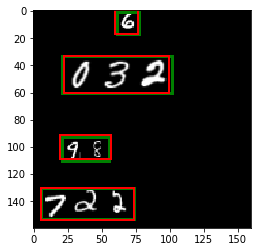

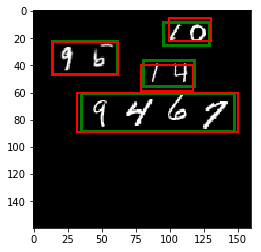

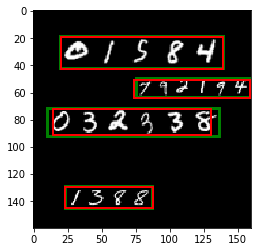

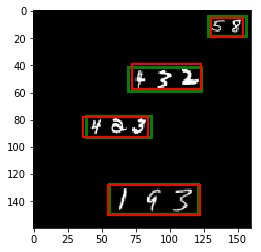

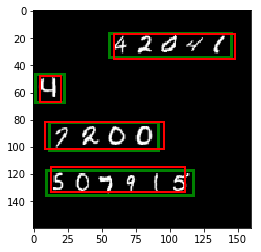

In [20]:
# Configurando o modo de avaliação
model_conv.eval()

# Pegando um batch da validação
# xs, ys = next(iter(dataloader_val))
xs, ys = next(iter(dataloader_train))

# Fazendo a predição do batch
pred_s1, pred_s2 = model_conv(xs.cuda())

print("Green: target, Red: predict")

# Plotando o predict do batch
count = 0
for x, y1, y2, pred1, pred2 in zip(xs, ys[0], ys[1], pred_s1, pred_s2):
    CustmizedMNISTUtil.show_sample(x, [y1, y2], [pred1, pred2])
    count += 1
    if count == 5: break